## 目录
1. 因子比较与筛选
2. 常用的因子预处理方法-调整正负、去极值、行业市值中性化、标准化
3. 多因子组合方法

In [1]:
from jaqs_fxdayu.data import DataView 
import warnings

warnings.filterwarnings("ignore")
dataview_folder = './Factor'
dv = DataView()
dv.load_dataview(dataview_folder)
dv.add_formula("momentum", "Return(close_adj, 20)", is_quarterly=False, add_data=True)

Dataview loaded successfully.


symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000012.SZ,000024.SZ,000027.SZ,000039.SZ,000046.SZ,000059.SZ,...,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603288.SH,603699.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20140102,-0.100735,-0.085812,-0.057592,-0.006342,-0.100442,-0.051708,-0.068143,0.012426,-0.074534,-0.089580,...,-0.140442,NaN,-0.065375,0.104574,NaN,NaN,NaN,NaN,NaN,-0.084892
20140103,-0.111690,-0.102975,-0.052910,-0.040881,-0.116740,-0.078923,-0.082474,0.048699,-0.091097,-0.111111,...,-0.167112,NaN,-0.075426,0.105497,NaN,NaN,NaN,NaN,NaN,-0.091437
20140106,-0.121896,-0.137255,-0.095643,-0.059129,-0.165380,-0.111576,-0.106164,0.011311,-0.098121,-0.134470,...,-0.214003,NaN,-0.085575,0.132137,NaN,NaN,NaN,NaN,NaN,-0.123726
20140107,-0.118271,-0.138051,-0.109342,-0.060228,-0.174342,-0.122535,-0.104991,0.039841,-0.095745,-0.139847,...,-0.200000,NaN,-0.088020,0.076545,NaN,NaN,NaN,NaN,NaN,-0.118594
20140108,-0.115124,-0.144175,-0.159346,-0.063224,-0.179235,-0.160665,-0.093103,0.066347,-0.081023,-0.156604,...,-0.216033,NaN,-0.085575,0.118630,NaN,NaN,NaN,NaN,NaN,-0.127941
20140109,-0.079439,-0.126464,-0.149474,-0.050273,-0.171525,-0.145109,-0.087873,0.109015,-0.075107,-0.143411,...,-0.208683,NaN,-0.081481,0.118595,NaN,NaN,NaN,NaN,NaN,-0.157895
20140110,-0.070755,-0.134818,-0.147799,-0.048087,-0.186020,-0.158701,-0.097002,0.088464,-0.066667,-0.141199,...,-0.218260,NaN,-0.077114,0.032493,NaN,NaN,NaN,NaN,NaN,-0.150665
20140113,-0.075697,-0.152225,-0.117032,-0.038419,-0.189342,-0.207055,-0.083333,0.074930,-0.069414,-0.193490,...,-0.214888,NaN,-0.062344,0.109781,NaN,NaN,NaN,NaN,NaN,-0.113264
20140114,-0.080784,-0.142349,-0.100105,-0.044662,-0.089120,-0.187791,-0.063063,0.123944,-0.039560,-0.177007,...,-0.202797,NaN,-0.062814,0.100159,NaN,NaN,NaN,NaN,NaN,-0.094225


In [2]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()

接下来，我们对pb、pe、ps、float_mv、momentum五个因子进行比较、筛选

In [3]:
from jaqs_fxdayu.research.signaldigger import multi_factor

ic = dict()
factors_dict = {signal:dv.get_ts(signal) for signal in ["pb","pe","ps","float_mv","momentum"]}
for period in [5, 15, 30]:
    ic[period]=multi_factor.get_factors_ic_df(factors_dict,
                                              price=dv.get_ts("close_adj"),
                                              high=dv.get_ts("high_adj"), # 可为空
                                              low=dv.get_ts("low_adj"),# 可为空
                                              n_quantiles=5,# quantile分类数
                                              mask=mask,# 过滤条件
                                              can_enter=can_enter,# 是否能进场
                                              can_exit=can_exit,# 是否能出场
                                              period=period,# 持有期
                                              benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                              commission = 0.0008,
                                              )

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective da

In [4]:
import pandas as pd
ic_mean_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
ic_std_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
ir_table = pd.DataFrame(data=np.nan,columns=[5,15,30],index=["pb","pe","ps","float_mv","momentum"])
for signal in ["pb","pe","ps","float_mv","momentum"]:
    for period in [5, 15, 30]:
        ic_mean_table.loc[signal,period]=ic[period][signal].mean()
        ic_std_table.loc[signal,period]=ic[period][signal].std()
        ir_table.loc[signal,period]=ic[period][signal].mean()/ic[period][signal].std()

print(ic_mean_table)
print(ic_std_table)
print(ir_table)

                5         15        30
pb       -0.045915 -0.077320 -0.117015
pe       -0.038581 -0.064546 -0.095852
ps       -0.030755 -0.054824 -0.084486
float_mv -0.000019  0.008395  0.027459
momentum -0.049655 -0.062483 -0.058243
                5         15        30
pb        0.229864  0.258433  0.245398
pe        0.211099  0.222946  0.215375
ps        0.178680  0.198704  0.193410
float_mv  0.220951  0.228495  0.223991
momentum  0.203428  0.212723  0.208409
                5         15        30
pb       -0.199748 -0.299188 -0.476838
pe       -0.182763 -0.289515 -0.445044
ps       -0.172122 -0.275909 -0.436822
float_mv -0.000084  0.036740  0.122589
momentum -0.244090 -0.293731 -0.279466


可视化比较

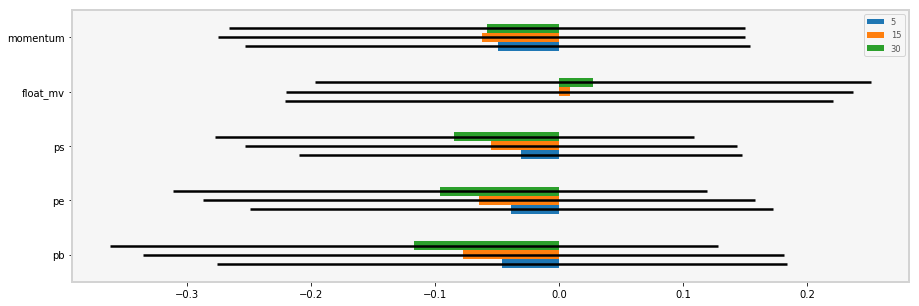

In [5]:
%matplotlib inline
ic_mean_table.plot(kind="barh",xerr=ic_std_table,figsize=(15,5))

* IC_IR:方差标准化后的ic均值
* 一般而言，认为|IC_IR|>0.6,因子的稳定性合格

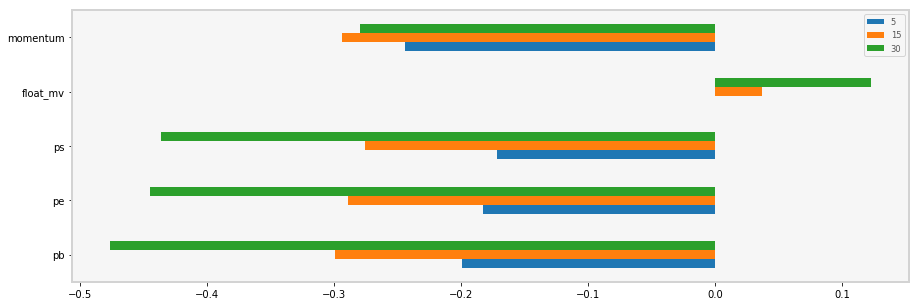

In [6]:
%matplotlib inline
ir_table.plot(kind="barh",figsize=(15,5))

### 因子预处理
保留momentum、ps、pe、pb 进一步处理并尝试构建组合因子

* 根据之前的分析，这几个因子在几个持有期下与股票收益的关系（ic）都是负的，先统一调整成正相关关系
* 去极值
* 标准化 -- z-score、rank
* 行业市值中性化


In [7]:
from jaqs_fxdayu.research.signaldigger import process

factor_dict = dict()
index_member = dv.get_ts("index_member")
for name in ["pb","pe","ps","momentum"]:
    signal = -1*dv.get_ts(name) # 调整符号
    process.winsorize(factor_df=signal,alpha=0.05,index_member=index_member)#去极值
    signal = process.standardize(signal,index_member) #z-score标准化 保留排序信息和分布信息
#     signal = process.rank_standardize(signal,index_member) #因子在截面排序并归一化到0-1(只保留排序信息)
#     # 行业市值中性化
#     signal = process.neutralize(signal,
#                                 group=dv.get_ts("sw1"),# 行业分类标准
#                                 float_mv = dv.get_ts("float_mv"), #流通市值 可为None 则不进行市值中性化
#                                 index_member=index_member,# 是否只处理时只考虑指数成份股
#                                 )
    factor_dict[name] = signal

### 多因子组合
对筛选后的因子进行组合，一般有以下常规处理：
* 因子间存在较强同质性时，先使用施密特正交化方法对因子做正交化处理，用得到的正交化残差作为因子（也可以不使用，正交化会破坏因子的经济学逻辑，并剔除一些信息）
* 因子组合加权，常规的方法有：等权重、以某个时间窗口的滚动平均ic为权重、以某个时间窗口的滚动ic_ir为权重、最大化上个持有期的ic_ir为目标处理权重、最大化上个持有期的ic为目标处理权重
* 注:因为计算IC需要用到下一期股票收益,因此在动态加权方法里，实际上使用的是前一期及更早的IC值(向前推移了holding_period)计算当期的权重

In [8]:
# 因子间存在较强同质性时，使用施密特正交化方法对因子做正交化处理，用得到的正交化残差作为因子
new_factors = multi_factor.orthogonalize(factors_dict=factor_dict,
                           standardize_type="rank",#输入因子标准化方法，有"rank"（排序标准化）,"z_score"(z-score标准化)两种（"rank"/"z_score"）
                           winsorization=False,#是否对输入因子去极值
                           index_member=index_member) #　是否只处理指数成分股

In [9]:
new_factors

{'momentum': symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
 trade_date                                                                     
 20140102     0.715719   0.511706        NaN   0.354515   0.290970   0.709030   
 20140103     0.668896   0.491639        NaN   0.351171   0.264214   0.655518   
 20140106     0.722408   0.488294        NaN   0.354515   0.230769   0.645485   
 20140107     0.725753   0.488294        NaN   0.384615   0.190635   0.605351   
 20140108     0.745819   0.498328        NaN   0.367893   0.200669   0.471572   
 20140109     0.816054   0.531773        NaN   0.371237   0.234114   0.511706   
 20140110     0.856187   0.505017        NaN   0.394649   0.227425   0.474916   
 20140113     0.842809   0.484950        NaN   0.444816   0.220736   0.334448   
 20140114     0.812709   0.418060        NaN   0.290970   0.414716   0.341137   
 20140115     0.792642   0.451505        NaN   0.397993   0.464883   0.337793   
 20140116     0.

用正交化前的因子，分别进行等权、以某个时间窗口的滚动平均ic为权重、以某个时间窗口的滚动ic_ir为权重、最大化上个持有期的ic_ir为目标处理权重、最大化上个持有期的ic为目标处理权重的加权组合方式，然后测试组合因子表现

In [10]:
# rollback_period代表滚动窗口所用到的天数,即用前多少期的数据来计算现阶段的因子权重。 通常建议设置时间在半年以上,可以获得相对稳定的预期结果

#  多因子组合-动态加权参数配置
props = {
    'price':dv.get_ts("close_adj"),
    'high':dv.get_ts("high_adj"), # 可为空
    'low':dv.get_ts("low_adj"),# 可为空
    'ret_type': 'return',#可选参数还有upside_ret/downside_ret 则组合因子将以优化潜在上行、下行空间为目标
    'benchmark_price': dv.data_benchmark,  # 为空计算的是绝对收益　不为空计算相对收益
    'period': 30, # 30天的持有期
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "shrink",  # 协方差矩阵估算方法 还可以为"simple"
    "rollback_period": 120}  # 滚动窗口天数

In [11]:
comb_factors = dict()
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    comb_factors[method] = multi_factor.combine_factors(factor_dict,
                                                        standardize_type="rank",
                                                        winsorization=False,
                                                        weighted_method=method,
                                                        props=props)
    print(method)
    print(comb_factors[method].dropna(how="all").head())

equal_weight
symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
trade_date                                                                     
20140102     0.762542   0.819398        NaN   0.143813   0.397993   0.628763   
20140103     0.745819   0.822742        NaN   0.187291   0.401338   0.648829   
20140106     0.712375   0.842809        NaN   0.190635   0.434783   0.678930   
20140107     0.705686   0.849498        NaN   0.190635   0.458194   0.702341   
20140108     0.678930   0.842809        NaN   0.204013   0.444816   0.769231   

symbol      000027.SZ  000039.SZ  000046.SZ  000059.SZ    ...      601992.SH  \
trade_date                                                ...                  
20140102          NaN   0.464883   0.364548        NaN    ...       0.909699   
20140103          NaN   0.431438   0.377926        NaN    ...       0.939799   
20140106          NaN   0.441472   0.351171        NaN    ...       0.943144   
20140107          NaN   0.

### 比较组合前和组合后的因子在30日持有期下的表现（统一到2014年9月后进行比较）

In [12]:
period = 30
ic_30  =   multi_factor.get_factors_ic_df(comb_factors,
                                          price=dv.get_ts("close_adj"),
                                          high=dv.get_ts("high_adj"), # 可为空
                                          low=dv.get_ts("low_adj"),# 可为空
                                          n_quantiles=5,# quantile分类数
                                          mask=mask,# 过滤条件
                                          can_enter=can_enter,# 是否能进场
                                          can_exit=can_exit,# 是否能出场
                                          period=period,# 持有期
                                          benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                          commission = 0.0008,
                                          )
ic_30 = pd.concat([ic_30,-1*ic[30].drop("float_mv",axis=1)],axis=1)
ic_30.head()

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 49%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 49%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 49%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


,equal_weight,ic_weight,ir_weight,max_IR,max_IC,pb,pe,ps,momentum
trade_date,,,,,,,,,
20140102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20140103,-0.047022,NaN,NaN,NaN,NaN,-0.053452,-0.018868,-0.004815,-0.050376
20140106,-0.075316,NaN,NaN,NaN,NaN,-0.085169,-0.053065,-0.018863,-0.065761
20140107,0.027397,NaN,NaN,NaN,NaN,0.026080,0.023327,0.056947,0.013767
20140108,0.131598,NaN,NaN,NaN,NaN,0.084470,0.081776,0.158562,0.132212


In [13]:
ic_30_mean = dict()
ic_30_std = dict()
ir_30 = dict()
for name in ic_30.columns:    
    ic_30_mean[name]=ic_30[name].loc[20140901:].mean()
    ic_30_std[name]=ic_30[name].loc[20140901:].std()
    ir_30[name] = ic_30_mean[name]/ic_30_std[name]

In [14]:
import datetime

trade_date = pd.Series(ic_30.index)
trade_date = trade_date.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
ic_30.index = trade_date

可视化比较

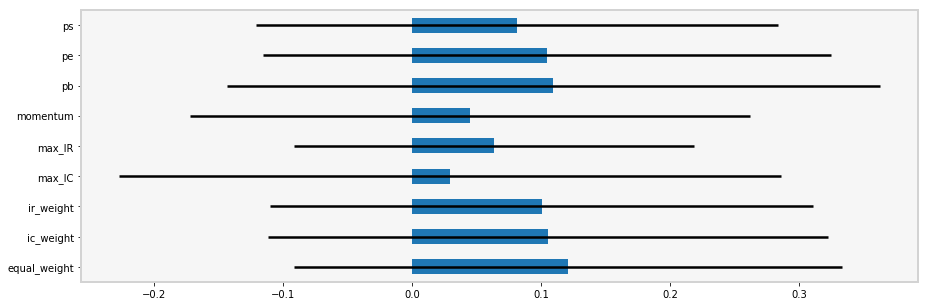

In [15]:
pd.Series(ic_30_mean).plot(kind="barh",xerr=pd.Series(ic_30_std),figsize=(15,5))

In [16]:
print(ic_30_mean["equal_weight"])
print(ic_30_mean["ic_weight"])
print(ic_30_mean["pe"])

0.12073068936069978
0.10512971417144427
0.10438725026905876


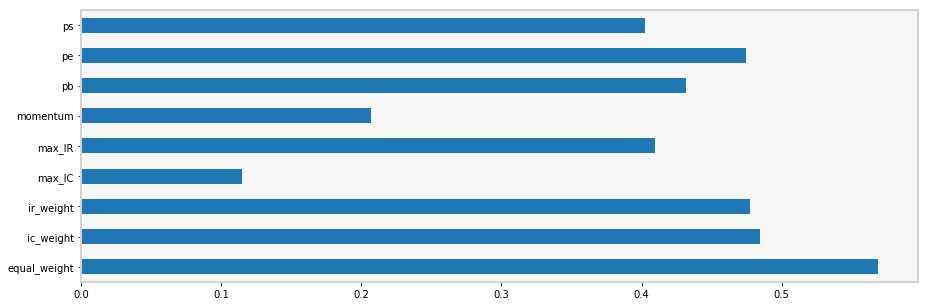

In [17]:
pd.Series(ir_30).plot(kind="barh",figsize=(15,5))

In [18]:
print(ir_30["equal_weight"])
print(ir_30["ic_weight"])
print(ir_30["pe"])

0.5686486313274169
0.48476009429523187
0.47457282064911344


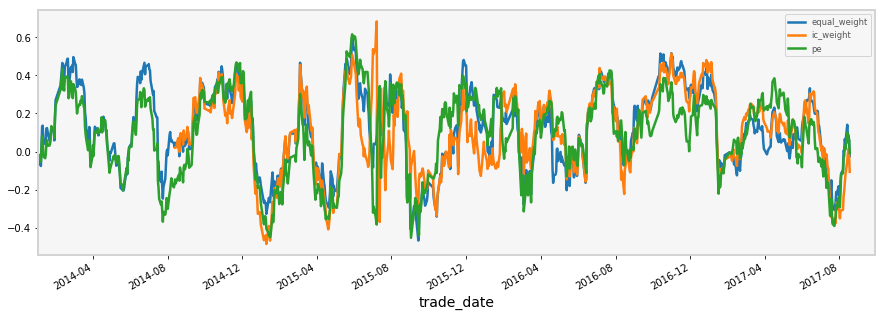

In [19]:
ic_30[["equal_weight","ic_weight","pe"]].plot(kind="line",figsize=(15,5),)

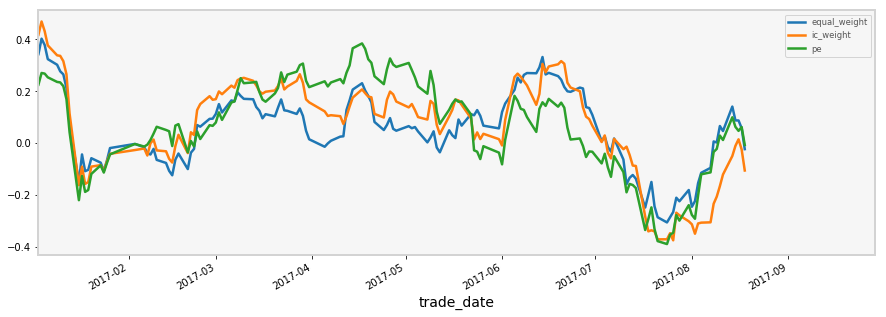

In [20]:
ic_30.loc[datetime.date(2017,1,3):,][["equal_weight","ic_weight","pe"]].plot(kind="line",figsize=(15,5),)

### 查看等权合成因子的详情报告

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%


Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1         0.000000  0.538462  0.103261  0.060651  51770  20.146791
2         0.180602  0.628763  0.307896  0.059901  51396  20.001245
3         0.371237  0.695652  0.509498  0.059105  51370  19.991127
4         0.565217  0.846154  0.708293  0.057892  51396  20.001245
5         0.755853  1.000000  0.904357  0.056350  51032  19.859591
Figure saved: /home/xinger/Desktop/qtc/多因子选股模型/returns_report.pdf
Information Analysis
                 ic
IC Mean       0.125
IC Std.       0.209
t-stat(IC)   17.758
p-value(IC)   0.000
IC Skew      -0.171
IC Kurtosis  -0.764
Ann. IR       0.597
Figure saved: /home/xinger/Desktop/qtc/多因子选股模型/information_report.pdf


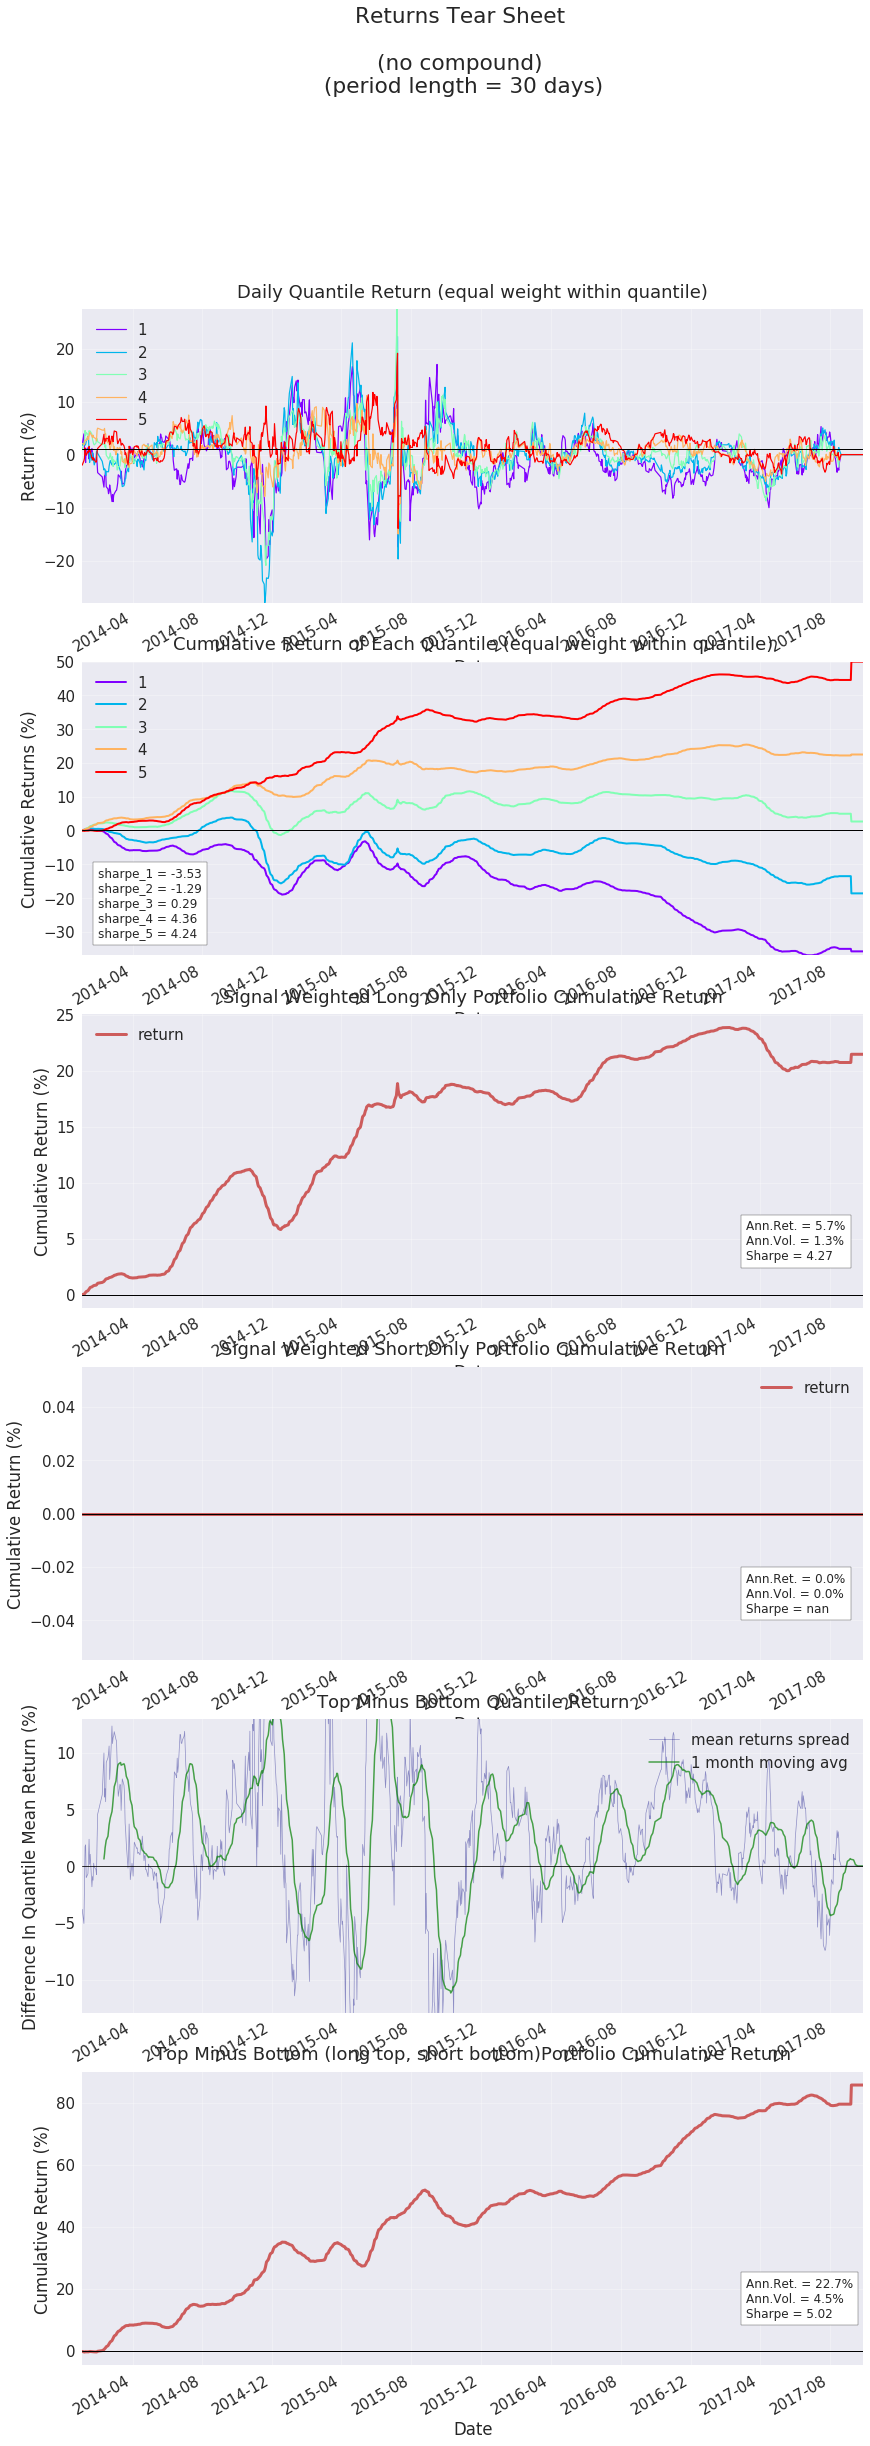

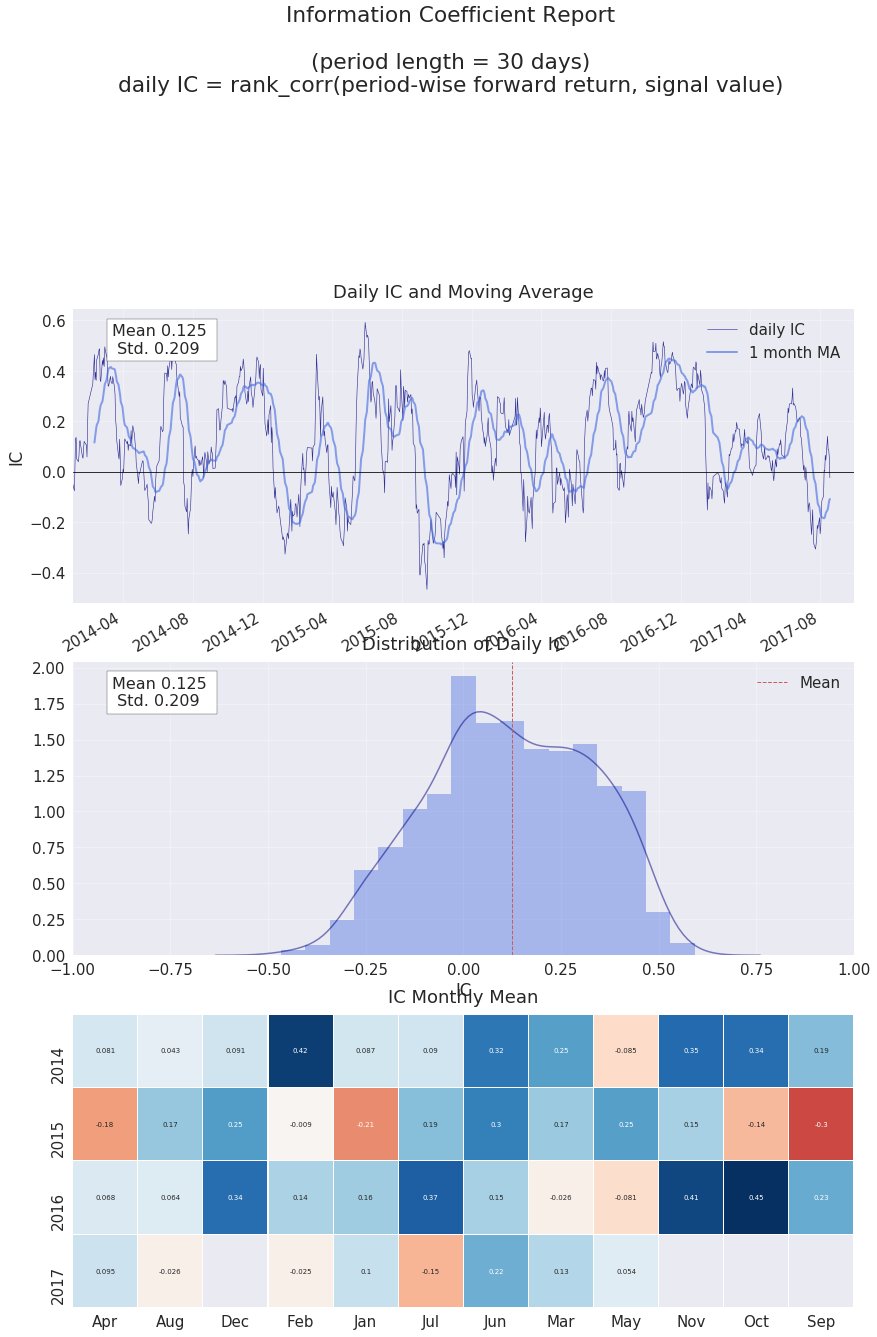

In [21]:
import matplotlib.pyplot as plt
from jaqs_fxdayu.research.signaldigger.analysis import analysis
from jaqs_fxdayu.research import SignalDigger

obj = SignalDigger()
obj.process_signal_before_analysis(signal=comb_factors["equal_weight"],
                                   price=dv.get_ts("close_adj"),
                                   high=dv.get_ts("high_adj"), # 可为空
                                   low=dv.get_ts("low_adj"),# 可为空
                                   n_quantiles=5,# quantile分类数
                                   mask=mask,# 过滤条件
                                   can_enter=can_enter,# 是否能进场
                                   can_exit=can_exit,# 是否能出场
                                   period=30,# 持有期
                                   benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                   commission = 0.0008,
                                   )
obj.create_full_report()
plt.show()

In [22]:
print(analysis(obj.signal_data,is_event=False,period=30))

{'ic':                 return_ic  upside_ret_ic  downside_ret_ic
IC Mean      1.247252e-01      -0.012185     2.604833e-01
IC Std.      2.090651e-01       0.202819     1.871202e-01
t-stat(IC)   1.775782e+01      -1.788293     4.143583e+01
p-value(IC)  1.404327e-60       0.074071    1.873265e-209
IC Skew     -1.714002e-01       0.297758    -5.568998e-01
IC Kurtosis -7.644106e-01      -0.779115     6.324959e-02
Ann. IR      5.965856e-01      -0.060079     1.392064e+00, 'ret':              long_ret  long_short_ret  top_quantile_ret  bottom_quantile_ret  \
t-stat       8.345612       11.909596         33.564165           -18.003623   
p-value      0.000000        0.000000          0.000000             0.000000   
skewness     0.050514        0.302533          2.210412             1.401058   
kurtosis     6.671800        1.616995         14.291204             6.855082   
Ann. Ret     0.054801        0.086260          0.119795            -0.090039   
Ann. Vol     0.069935        0.077139    

进一步测试下等权合成因子的绝对收益效果

Nan Data Count (should be zero) : 0;  Percentage of effective data: 59%


Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1         0.000000  0.538462  0.103261  0.060651  51770  20.146791
2         0.180602  0.628763  0.307896  0.059901  51396  20.001245
3         0.371237  0.695652  0.509498  0.059105  51370  19.991127
4         0.565217  0.846154  0.708293  0.057892  51396  20.001245
5         0.755853  1.000000  0.904357  0.056350  51032  19.859591
Figure saved: /home/xinger/Desktop/qtc/多因子选股模型/returns_report.pdf
Information Analysis
                 ic
IC Mean       0.126
IC Std.       0.209
t-stat(IC)   17.882
p-value(IC)   0.000
IC Skew      -0.174
IC Kurtosis  -0.764
Ann. IR       0.601
Figure saved: /home/xinger/Desktop/qtc/多因子选股模型/information_report.pdf


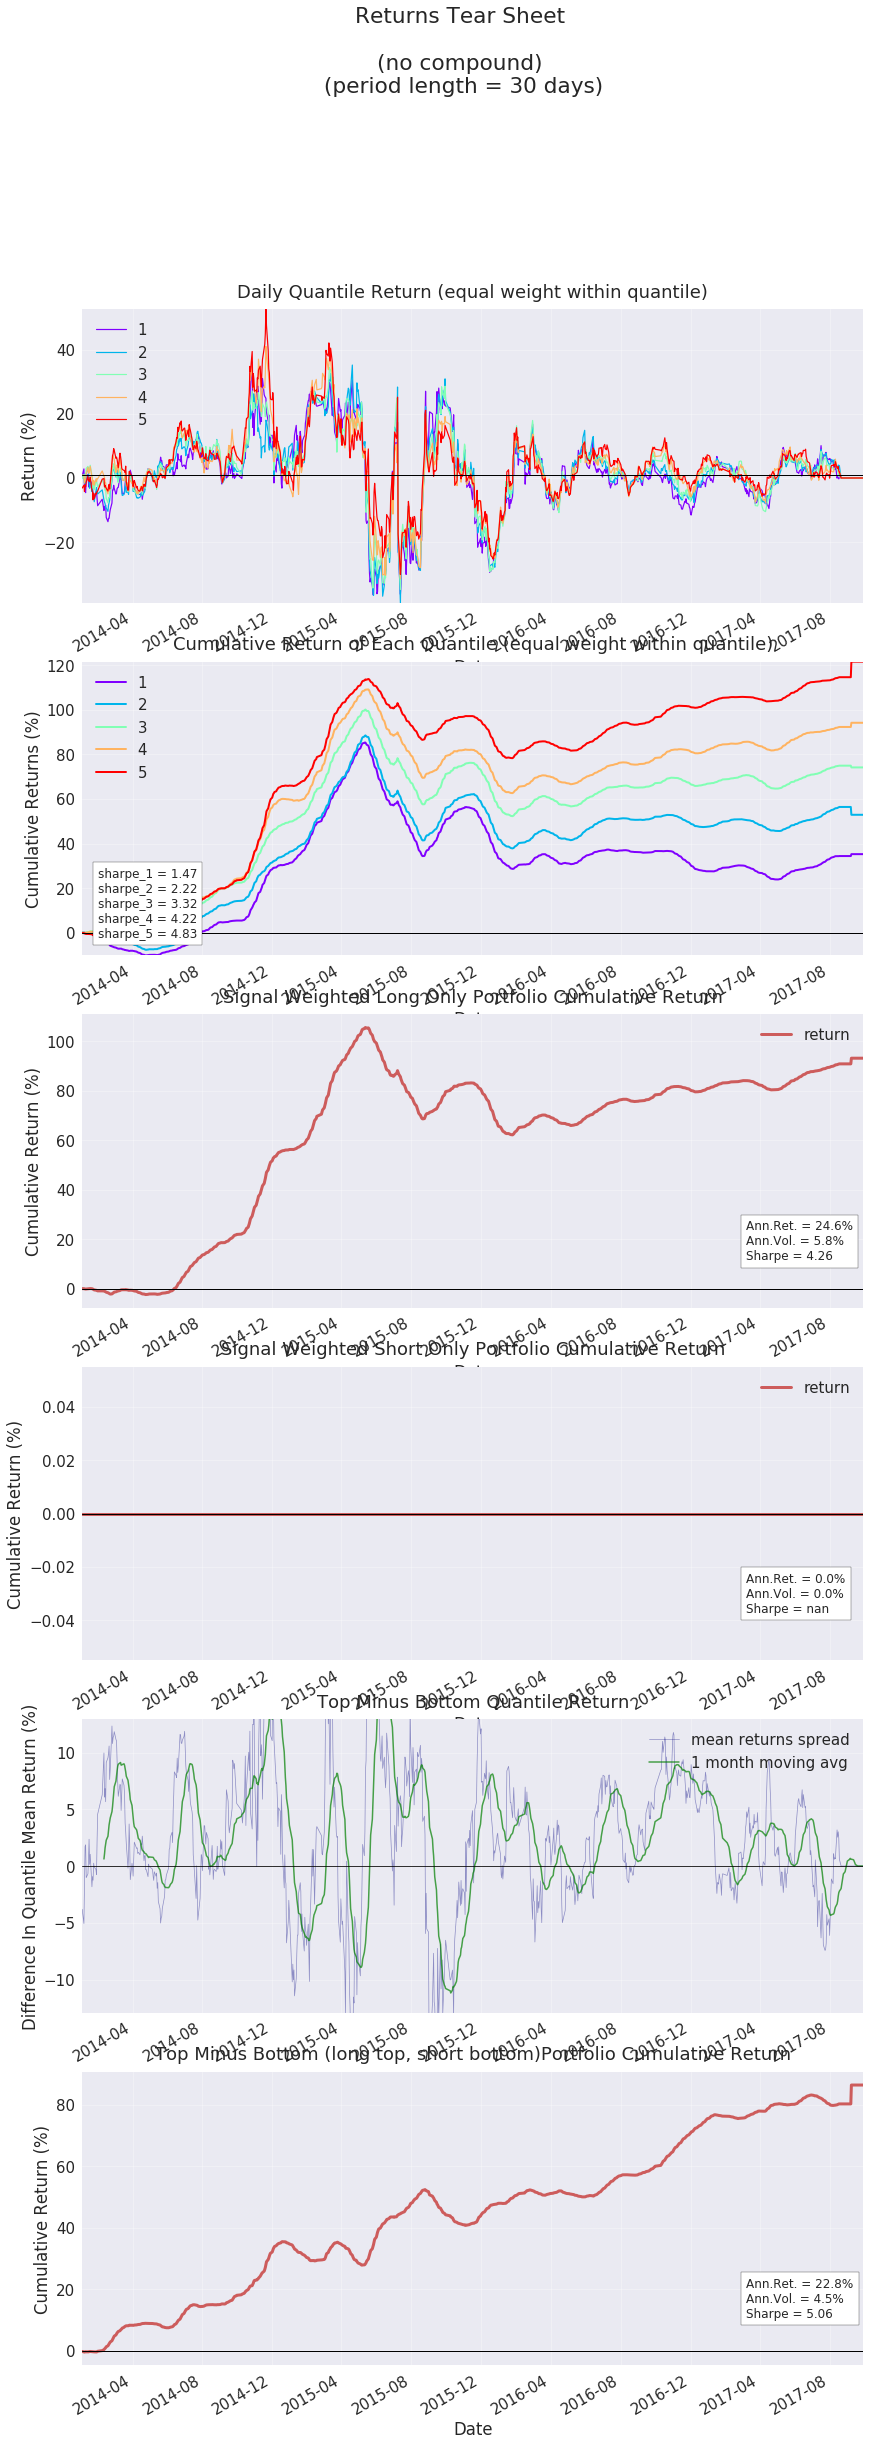

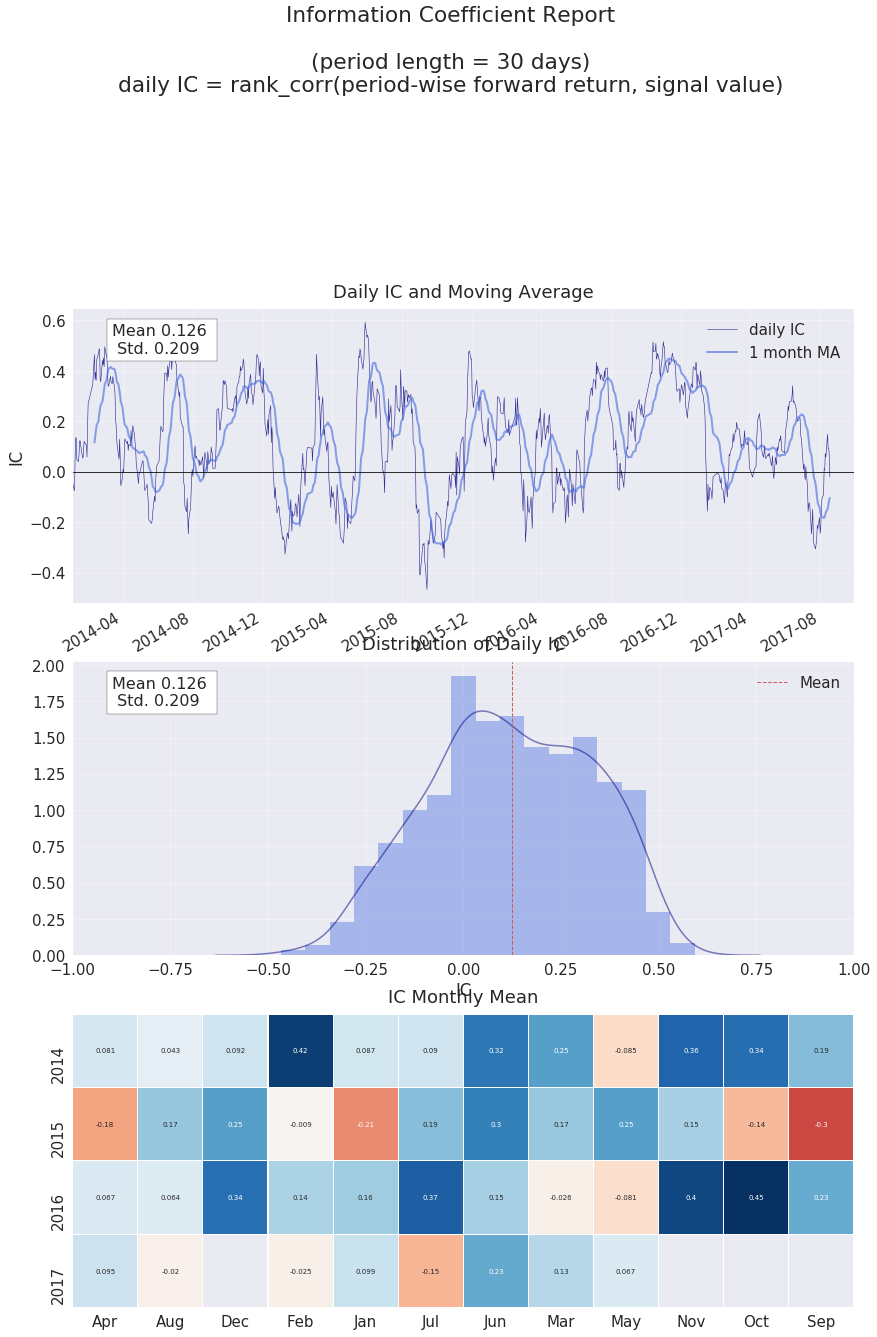

In [23]:
obj.process_signal_before_analysis(signal=comb_factors["equal_weight"],
                                   price=dv.get_ts("close_adj"),
                                   high=dv.get_ts("high_adj"), # 可为空
                                   low=dv.get_ts("low_adj"),# 可为空
                                   n_quantiles=5,# quantile分类数
                                   mask=mask,# 过滤条件
                                   can_enter=can_enter,# 是否能进场
                                   can_exit=can_exit,# 是否能出场
                                   period=30,# 持有期
                                   #benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                   commission = 0.0008,
                                   )
obj.create_full_report()
plt.show()

## 将Quantile5的选股结果保存成excel

In [24]:
excel_data = obj.signal_data[obj.signal_data['quantile']==5]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
print (excel_data.head())
excel_data.to_excel('./equal_weight_quantile_5.xlsx')

symbol      000001.SZ  000002.SZ  000012.SZ  000024.SZ  000027.SZ  000039.SZ  \
trade_date                                                                     
20140103          0.0        1.0        0.0        0.0        0.0        0.0   
20140106          0.0        1.0        0.0        0.0        0.0        0.0   
20140107          0.0        1.0        0.0        0.0        0.0        0.0   
20140108          0.0        1.0        0.0        0.0        0.0        0.0   
20140109          0.0        1.0        0.0        0.0        0.0        0.0   

symbol      000063.SZ  000069.SZ  000100.SZ  000157.SZ    ...      601919.SH  \
trade_date                                                ...                  
20140103          1.0        0.0        0.0        1.0    ...            0.0   
20140106          1.0        0.0        0.0        1.0    ...            0.0   
20140107          0.0        0.0        0.0        1.0    ...            0.0   
20140108          0.0        0.0       